# Distributed Coffea Jobs at UW Analysis Facility

This notebook demonstrates how one can run a full coffea (version pre-2023 ie: 0.7) analysis with Condor jobs on the Analysis Facility's cluster. As with the other notebooks, you should have already run your `voms-proxy-init` command in a terminal window before running anything here, as this example does access files remotely with XRootD.

As of January 2024, this notebook can also be used as a template for many coffea v0.7 analyses. We hope to develop some simplifications in terms of the Condor setup, but this template should at least get an analysis up and running with some tweaks.

In [7]:
from dask.distributed import Client
import os
from dask_jobqueue import HTCondorCluster
import awkward as ak
import coffea.processor as processor
from hist import Hist, axis
from coffea.analysis_tools import PackedSelection
from coffea.nanoevents import NanoAODSchema
from coffea.nanoevents.methods import nanoaod

We'll configure some settings here to be used later.

`MAX_WORKERS`: The maximum number of Condor workers to try and use at a time.<br>
`CHUNKSIZE`: The number of events in one chunk. Unless you have a reason to use something else, 10,000 and 5,000 are decent starting points.<br>
`MAX_CHUNKS`: The maximum number of chunks to run over. For example, if you want to run on only 20,000 events and your chunk size is 5,000, you could set MAX_CHUNKS to 4.

In [8]:
MAX_WORKERS = 5
CHUNKSIZE = 5000
MAX_CHUNKS = None

Next, we define our fileset. The fileset should be a dictionary mapping dataset names to lists of files. We are using XRootD for file access here, so we give the file addresses with the FNAL redirector. You can also put local files here.

In [17]:
redirector = "root://cmsxrootd.fnal.gov//"

ll_fileset = {
    "ggZH_HToBB_ZToLL": [
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ggZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/1412A75E-6CBA-5142-914D-2FE8356F680C.root",
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ggZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/7D3C5290-C72C-B140-9233-D7DA01D4B183.root"
    ],
    "ZH_HToBB_ZToLL": [
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/56097D21-719D-564E-8E4A-C65214F252F9.root",
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2820000/FE6AF237-7A43-C640-A0C0-672C18B80526.root"
    ]
}

Now, we write the coffea processor. This contains the logic and "physics" of our analysis. To make sure the class has the right structure, we inherit from the class `coffea.processor.ProcessorABC`. Our analysis goes primarily under the `process` method, which is mandatory. It should return an accumulatable object, as in the previous example notebook on accumulators and Hist.

For more examples of how processors (and other coffea analyses) can look, see [this Github discussion](https://github.com/CoffeaTeam/coffea/discussions/829).

In [18]:
class ExampleProcessor(processor.ProcessorABC):

    def __init__(self):
        #Initialize Coffea processor
        ak.behavior.update(nanoaod.behavior)

        ### Accumulator for holding histograms and value counts
        self._accumulator = {}

    @property
    def accumulator(self):
        return self._accumulator

    def process(self,events):
        dataset = events.metadata["dataset"]

        myAxis = axis.Regular(10,0,100,name='data',label='example data')

        output = {}
        output[dataset] = {
            "EventCount": processor.value_accumulator(int),
            "Test": processor.value_accumulator(int),
            "OtherTest": processor.value_accumulator(int),
            "MyHist": Hist(myAxis)
        }

        #Do some physics here (make cuts, select objects, calculate masses, etc.)
        
        #Fill in output
        output[dataset]["Test"] += ak.sum(ak.ones_like(events.Electron.pt))
        output[dataset]["OtherTest"] += ak.prod(ak.where(events.Electron.charge < 0, 5, -2))
        output[dataset]["EventCount"] += len(events)
        output[dataset]["MyHist"].fill(25)

        return output

    def postprocess(self,accumulator):
        return accumulator

Now, we want to run this processor. We'll do it locally first, which is always good for testing, and then we'll run it on the cluster.

We start by making an executor object, which tells coffea how we want to run our processor. In this case, we create an `IterativeExecutor`, which runs locally. Then, we pass that executor, our processor, and our fileset to a `Runner`, which actually runs our analysis code. Note that when we create the runner, we assume the tree of interest in each ROOT file is called "Events". One can also run on non-ROOT files like parquet, or with different tree names. For this, see the coffea documentation and examples linked above.

In [19]:
#Create the executor, and have a status bar to show progress
local_executor = processor.IterativeExecutor(status=True)

#Create the runner
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=local_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 5000 and maxchunks None


In [20]:
print("Calling runner")
ll_results_local = runner(
    ll_fileset,
    treename="Events",
    processor_instance=ExampleProcessor(),
)

Output()

Calling runner


Now that we ran our processor, we can examine the results, and then move on to running our jobs through Condor.

Dataset: ZH_HToBB_ZToLL
Event count: 300312
Test value: value_accumulator(int, 337925.0)
Other test value: value_accumulator(int, 0)
Dataset: ggZH_HToBB_ZToLL
Event count: 14000
Test value: value_accumulator(int, 19245.0)
Other test value: value_accumulator(int, 0)


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe248cc48e0>, errorbar=None, legend_artist=None)]

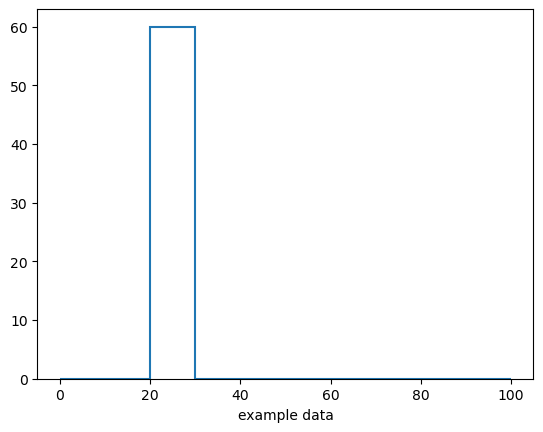

In [21]:
for dset,results in ll_results_local.items():
    print(f"Dataset: {dset}")
    print(f"Event count: {results['EventCount'].value}")
    print(f"Test value: {results['Test']}")
    print(f"Other test value: {results['OtherTest']}")

ll_results_local["ZH_HToBB_ZToLL"]["MyHist"].plot()

This next cell gets you ready to run on Condor, including taking any specifications the user needs to make for the Condor cluster.

It is important to make sure that the `+SingularityImage` ClassAd points to the same image as the one that is running JupyterLab right now. To check this, go to the top left corner of JupyterLab and click File->Hub Control Panel. <b>Make sure</b> that the image name there (starting with "coffeateam/") matches the `+SingularityImage` value in the cell below. This is a common source of errors.

In [10]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

PWD = os.getcwd()
print(f'Transferring contents of {PWD} to workers')
INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=1,
    memory="2 GB",
    disk="1 GB",
    death_timeout = '60',
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "+SingularityImage": '"/cvmfs/unpacked.cern.ch/registry.hub.docker.com/coffeateam/coffea-dask:0.7.22-py3.10-g7cbcc"',
        "Requirements": "HasSingularityJobStart",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path}'
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=1, maximum=MAX_WORKERS)
client = Client(cluster)
dask_executor = processor.DaskExecutor(client=client, status=True)
print("Executor created")

client

Transferring contents of /afs/hep.wisc.edu/user/rsimeon/examples to workers
Condor logs, output files, error files in /scratch/rsimeon
Executor created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:32681,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


The above cell should have produced a `Client` object, with a button that says "Launch dashboard in JupyterLab". Clicking that button will allow you to see the memory usage and worker status of your Condor workers in roughly real time. We also created an executor object, much like when we ran locally, except now it is a `DaskExecutor`, which knows about our Condor workers and gives them jobs.

The next cells create another runner with our Dask executor, and then runs the distributed jobs. You should be able to see your jobs moving in the dashboard, but it may take a few minutes. Running the jobs should finish in under 10 minutes.

In [11]:
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=dask_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 5000 and maxchunks None


In [12]:
print("Calling runner")
ll_results_dask = runner(
    ll_fileset,
    treename="Events",
    processor_instance=ExampleProcessor(),
)

Calling runner


Again, we can look at the results.

Dataset: ggZH_HToBB_ZToLL
Event count: 14000
Dataset: ZH_HToBB_ZToLL
Event count: 300312


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fbd2a5a0460>, errorbar=None, legend_artist=None)]

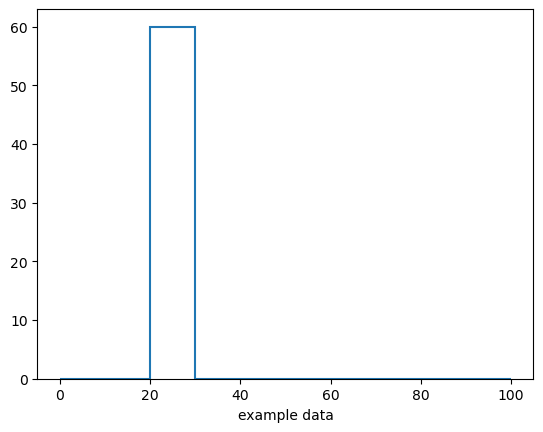

In [13]:
for dset,results in ll_results_dask.items():
    print(f"Dataset: {dset}")
    print(f"Event count: {results['EventCount'].value}")

ll_results_dask["ZH_HToBB_ZToLL"]["MyHist"].plot()

Finally, make sure to shut down your Condor client when you are done, just to avoid issues. If you forget, shutting down the notebook kernel also works.

In [14]:
client.shutdown()